<a href="https://colab.research.google.com/github/rramosp/2020.HEP.NEWPHYSICS/blob/master/02%20-%20histograms%20distribution%20formulation%20%2B%20MLE%20estimation%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.HEP.NEWPHYSICS/master/init.py
import init; init.init(force_download=False);

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from progressbar import progressbar as pbar
from local.lib import histos2d as h2d

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Asymptotic formulae for likelihood-based tests of new physics

https://arxiv.org/abs/1007.1727

Section 2 describes how to build a histogram $\mathbf{n}=(n_1,...,n_N)$ from measuring a variable $x$ that has a background and signal component. Each component distribution is predicted by some theory. A parameter $\mu \in [0,1]$ represents the degree of presence of signal ($\mu=0 \rightarrow$ only background, $\mu=1 \rightarrow$ signal + background).

We consider the process of building histograms many times and, thus, we have a distribution of histograms. The expected value of the number of measurements contained in bin $n_i$ can be written as:

$$\begin{equation*}
\mathbb{E}[n_i] = \mu s_i + b_i
\end{equation*}
\tag{1}
$$

and the mean number of entries of signal and background are:


$$\begin{equation*}
s_i = s_\text{tot}\int_{\text{bin }i} f_s(x;\boldsymbol{\theta}_s)dx\\
b_i = b_\text{tot}\int_{\text{bin }i} f_b(x;\boldsymbol{\theta}_b)dx
\end{equation*}
\tag{2}
$$

where

- $s_\text{tot}, b_\text{tot} \in [0,1]$ and $s_\text{tot}+b_\text{tot}=1$ is the porcentage of measurements coming from the signal and from the background respectively.
- $f_s(x;\boldsymbol{\theta}_s)$ and $f_b(x;\boldsymbol{\theta}_b)$ are the $pdf$'s for variable $x$ as coming from signal or background

finally, the distribution of each bin is given by a Poisson variable


$$\begin{equation*}
n_i \sim \text{Poisson}(\lambda_i) \;\;\; \text{ with } \lambda_i=\mu s_i + b_i\\
P(n_i; \mu, \boldsymbol{\theta}_s, \boldsymbol{\theta}_b, s_\text{tot}, b_\text{tot}) = P(n_i; \mu, \boldsymbol{\theta}, s_\text{tot} ) = \frac{\lambda_i^{n_i}}{n_i!}e^{-\lambda_i} = \frac{(\mu s_i + b_i)^{n_i}}{n_i!}e^{-(\mu s_i + b_i)}
\end{equation*}
\tag{3}
$$

with $\boldsymbol{\theta} = (\boldsymbol{\theta}_s, \boldsymbol{\theta}_b, b_\text{tot})$, assuming $s_\text{tot}$ is fixed given by the theory and focusing on $\mu$.

observe that for any random variable $Z \sim \text{Poisson}(\lambda)$ its expected value $\mathbb{E}[Z]=\lambda$ (see [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) and, since the random variable associated with each bin $n_i\sim \text{Poisson}(\lambda_i)$, then $\mathbb{E}[n_i] = \lambda_i = \mu s_i + b_i$

### background and signal distributions

In this notebook, we **assume** background and signal distributions are the following

- $b \sim \text{exp}(t)$ with pdf $f_b(x;\boldsymbol{\theta}_b)$ and   $\boldsymbol{\theta}_b=(t)\;\;\;\;$ we use $t$ instead of $\lambda$ as customary for the Exponential distribuion for convinience in Python code
- $s \sim \mathcal{N}(\mu_s, \sigma_s)$ with pdf $f_s(x;\boldsymbol{\theta}_s)$ and $\boldsymbol{\theta}_s=(\mu_s, \sigma_s)$

Also, a specification of $N$ bins is given in `bin_edges` $\in \mathbb{R}^{N+1}$


### log likelihood

for the moment we try to estimate $\mu$ assuming all the rest of parameters $ (\boldsymbol{\theta}, s_\text{tot}) $ are fixed.

Given **one** observed histogram, the log likelihood of a given $\mu$ is given by:


$$\mathcal{L}(\mu) = \log \prod_{i=1}^N \frac{(\mu s_i + b_i)^{\overline{n_i}}}{\overline{n_i}!}e^{-(\mu s_i + b_i)} =  \sum_{i=1}^N \overline{n_i} \log  (\mu s_i + b_i) - \log (\overline{n_i}!)-\mu s_i - b_i$$

where $\overline{n_i}$ is the observed count in bin $i$ and $s_i$ and $b_i$ are the analytical (theory predicted) quantities on eqs $(2)$ above. 

We want:


$$\text{MLE}(\mu) = \underset{\mu}{\text{arg max}} \;\;\mathcal{L}(\mu) $$

In [0]:
n_bins = 20
bin_edges = np.r_[list(np.linspace(0,180,n_bins))+[np.inf]]
bin_edges

array([  0.        ,   9.47368421,  18.94736842,  28.42105263,
        37.89473684,  47.36842105,  56.84210526,  66.31578947,
        75.78947368,  85.26315789,  94.73684211, 104.21052632,
       113.68421053, 123.15789474, 132.63157895, 142.10526316,
       151.57894737, 161.05263158, 170.52631579, 180.        ,
                inf])

### set up an experiment

In [0]:
e1 = h2d.BS_hist_experiment(t=0.03, mu_s=60, sigma_s=4, mu=1, stot=1000, btot=10000, bin_edges=bin_edges)

### the values for $\mathbb{E}[n_i]$, $s_i$ and $b_i$ as given by  eqs $(1)$ and $(2)$ above

In [0]:
e1.ni

array([2473.91815802, 1861.89105276, 1401.27444439, 1054.61063151,
        794.5031284 ,  811.47461093, 1177.4800157 ,  395.48588533,
        254.68548585,  191.64864765,  144.23634061,  108.5534504 ,
         81.69821519,   61.48674539,   46.2754278 ,   34.82726569,
         26.21128519,   19.72682775,   14.84657202,   45.16580943])

In [0]:
e1.si

array([7.07059435e-34, 5.16365626e-22, 1.45464216e-12, 1.63512626e-05,
       7.94548290e-01, 2.14123038e+02, 7.27908333e+02, 5.71345574e+01,
       3.95073245e-02, 1.34392830e-07, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [0]:
e1.bi

array([2473.91815802, 1861.89105276, 1401.27444439, 1054.61061516,
        793.70858011,  597.35157326,  449.57168288,  338.35132792,
        254.64597853,  191.64864751,  144.23634061,  108.5534504 ,
         81.69821519,   61.48674539,   46.2754278 ,   34.82726569,
         26.21128519,   19.72682775,   14.84657202,   45.16580943])

### we can sample histograms

In [0]:
sn, ss, sb = e1.sample_histograms(n_samples=20)

100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [0]:
sn.head()

bin_nb,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
sample_nb,,,,,,,,,,,,,,,,,,,,
0,2449,1855,1390,1023,817,897,1138,409,273,173,147,89,80,69,49,31,27,23,11,50
1,2433,1872,1416,1043,792,802,1211,371,298,208,139,112,70,62,46,25,19,19,12,50
2,2544,1839,1395,1072,810,807,1143,412,237,175,127,101,73,63,42,38,23,23,21,55
3,2535,1872,1394,997,770,805,1181,401,276,201,158,97,85,71,40,26,18,13,19,41
4,2467,1878,1421,1029,767,847,1155,394,242,184,128,129,90,74,49,34,34,12,11,55


In [0]:
ss.head()

bin_nb,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
sample_nb,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,1,249,682,68,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,2,208,737,53,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,206,718,76,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,216,723,60,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,243,698,58,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
sb.head()

bin_nb,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
sample_nb,,,,,,,,,,,,,,,,,,,,
0,2449,1855,1390,1023,816,648,456,341,273,173,147,89,80,69,49,31,27,23,11,50
1,2433,1872,1416,1043,790,594,474,318,298,208,139,112,70,62,46,25,19,19,12,50
2,2544,1839,1395,1072,810,601,425,336,237,175,127,101,73,63,42,38,23,23,21,55
3,2535,1872,1394,997,769,589,458,341,276,201,158,97,85,71,40,26,18,13,19,41
4,2467,1878,1421,1029,766,604,457,336,242,184,128,129,90,74,49,34,34,12,11,55


### analytical values and empirical sample means must match

100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


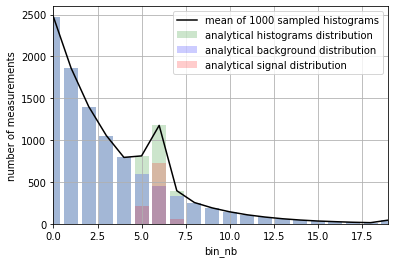

In [0]:
e1.plot_histograms_distribution()

### each bin of sampled histograms must match the analytical distribution in eq $(3)$ above

100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


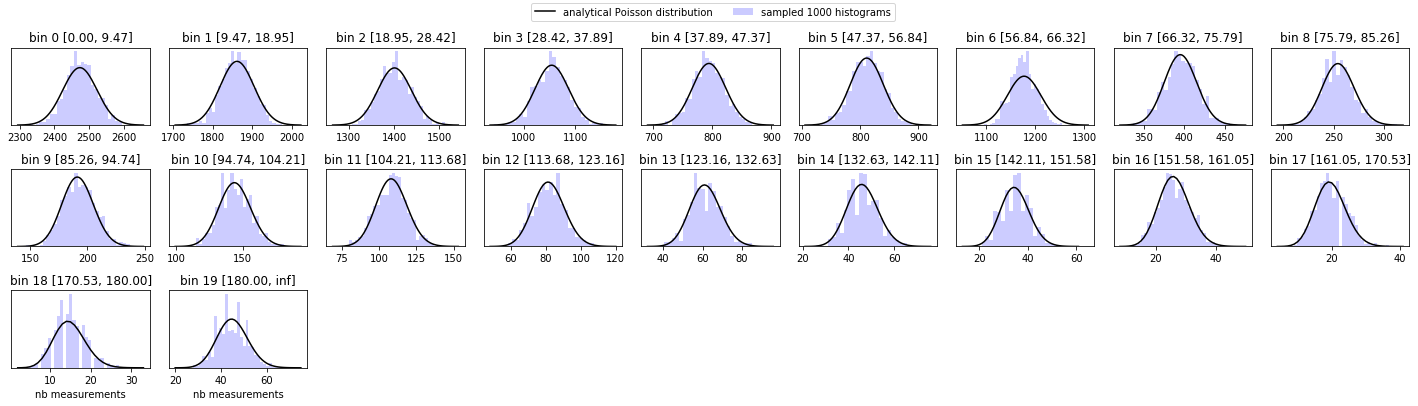

In [0]:
e1.plot_bin_distributions()

# In a real experiment we only have one histogram (and only $n_i$, not its decomposition in $s_i$ and $b_i$)

In [0]:
e1 = h2d.BS_hist_experiment(t=0.03, mu_s=60, sigma_s=4, mu=1, stot=1000, btot=10000, bin_edges=bin_edges)
sn, _,_ = e1.sample_histograms(n_samples=1)
sn

bin_nb,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
sample_nb,,,,,,,,,,,,,,,,,,,,
0,2476,1797,1408,1080,816,796,1190,386,248,201,160,113,75,62,49,39,27,19,12,46


In [0]:
e1.get_loglikelihood_estimate_for_mu(sn.values[0])

1.0044623671109274

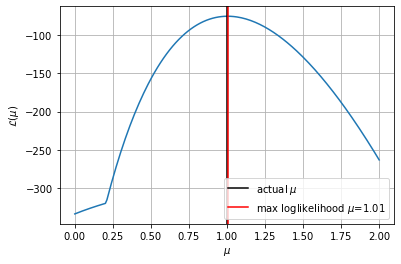

In [0]:
e1.plot_loglikelihood(sn.values[0])

### distribution of MLE for $\mu$ with 10,20 and 50 bins

100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (500 of 500) |######################| Elapsed Time: 0:01:44 Time:  0:01:44


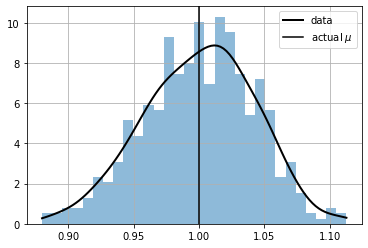

In [0]:
n_bins = 20
bin_edges = np.r_[list(np.linspace(0,180,n_bins))+[np.inf]]
self = h2d.BS_hist_experiment(t=0.03, mu_s=60, sigma_s=4, mu=1, stot=500, btot=5000, bin_edges=bin_edges)

sn, _,_ = self.sample_histograms(n_samples=500)
mle_mu = [self.get_loglikelihood_estimate_for_mu(i.values) for _,i in pbar(sn.iterrows(), max_value=len(sn))]
plt.hist(mle_mu, bins=30, alpha=.5, density=True);
h2d.plot_kdensity_smoothed_histogram(mle_mu)
plt.axvline(self.mu, color="black", label="actual $\mu$")
plt.legend(); plt.grid();

100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (500 of 500) |######################| Elapsed Time: 0:00:44 Time:  0:00:44


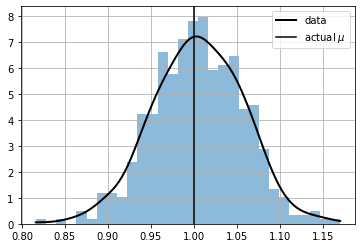

In [0]:
n_bins = 10
bin_edges = np.r_[list(np.linspace(0,180,n_bins))+[np.inf]]
self = h2d.BS_hist_experiment(t=0.03, mu_s=60, sigma_s=4, mu=1, stot=500, btot=5000, bin_edges=bin_edges)

sn, _,_ = self.sample_histograms(n_samples=500)
mle_mu = [self.get_loglikelihood_estimate_for_mu(i.values) for _,i in pbar(sn.iterrows(), max_value=len(sn))]
plt.hist(mle_mu, bins=30, alpha=.5, density=True);
h2d.plot_kdensity_smoothed_histogram(mle_mu)
plt.axvline(self.mu, color="black", label="actual $\mu$")
plt.legend(); plt.grid();

100% (500 of 500) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (500 of 500) |######################| Elapsed Time: 0:04:02 Time:  0:04:02


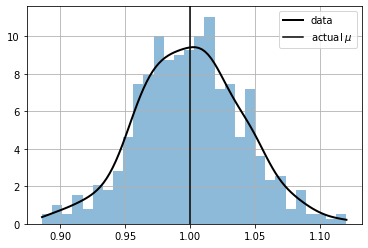

In [0]:
n_bins = 50
bin_edges = np.r_[list(np.linspace(0,180,n_bins))+[np.inf]]
self = h2d.BS_hist_experiment(t=0.03, mu_s=60, sigma_s=4, mu=1, stot=500, btot=5000, bin_edges=bin_edges)
sn, _,_ = self.sample_histograms(n_samples=500)
mle_mu = [self.get_loglikelihood_estimate_for_mu(i.values) for _,i in pbar(sn.iterrows(), max_value=len(sn))]
plt.hist(mle_mu, bins=30, alpha=.5, density=True);
h2d.plot_kdensity_smoothed_histogram(mle_mu)
plt.axvline(self.mu, color="black", label="actual $\mu$")
plt.legend(); plt.grid();